# Sentiment Analysis on aggregated data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [ ]:
df = pd.read_csv('aggregated.csv', index_col = [0])

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#sample sentiment analysis
sample_review = list(df['review_text'])[1]
result = sentiment_pipeline(sample_review)
result

[{'label': 'Positive', 'score': 0.9277957677841187}]

In [ ]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = []
index = -1
for sentence in df['review_lower']:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment.append(result['label'])
df['sentiment'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Zero shot classification

In [2]:
import transformers
from transformers import pipeline
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

# Sample classification

In [ ]:
sample_review = list(df['review_text'])[1]

res = classifier(
    sample_review,
    candidate_labels = ['affordability', 'quality', 'satisfaction', 'complaints'], 
    multi_label = True
)
res

{'sequence': 'The seeds mix is good',
 'labels': ['quality', 'satisfaction', 'affordability', 'complaints'],
 'scores': [0.9990378618240356,
  0.9383894205093384,
  0.0276698749512434,
  0.00023220224829856306]}

# Insert four labels (cost, efficient, effective, ease of use)

In [ ]:
type = ['cost', 'efficient', 'effective', 'ease of use']

In [ ]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0


C:\Users\WJ.DESKTOP-VH0S9RM\AppData\Local\Temp\ipykernel_10780\576072882.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]


20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Metric and sanity check

['the seeds mix is good']

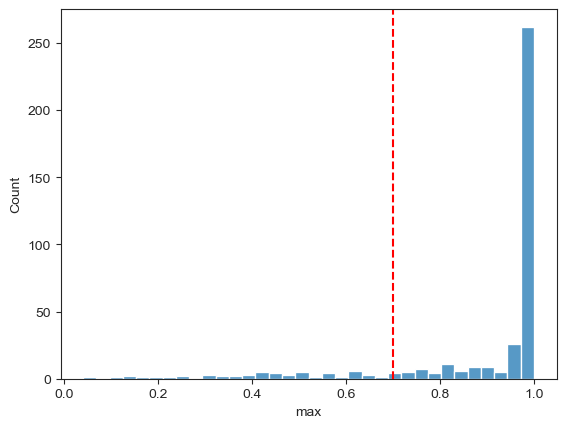

In [ ]:
# create a "max" column for metric purposes
df['max'] = df[['cost_m', 'efficient_m', 'effective_m', 'ease of use_m']].max(axis=1)

# append type to max
align_list=[]
for i in range(len(df)):
  for t in type:
    if df[t+'_m'].iloc[i] == df['max'].iloc[i]:
      align_list.append(t)
      
df['align_type']=align_list
sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'max', data = df);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');

list(df[df['max'] > 0.7]['review_lower'][1:2])

# How many remained uncategorized

In [ ]:
# to see how many uncategorized data remains
df_uncat = df[df['cost_m'] < 0.7]
df_uncat = df_uncat[df_uncat['efficient_m'] < 0.7]
df_uncat = df_uncat[df_uncat['effective_m'] < 0.7]
df_uncat = df_uncat[df_uncat['ease of use_m'] < 0.7]
len(df_uncat)

53

# Heatmap

<Figure size 1200x500 with 0 Axes>

[Text(0.5, 17.249999999999993, ''), Text(112.24999999999999, 0.5, '')]

[Text(0.5, 17.249999999999993, ''), Text(112.24999999999999, 0.5, '')]

[Text(0.5, 17.249999999999993, ''), Text(112.24999999999999, 0.5, '')]

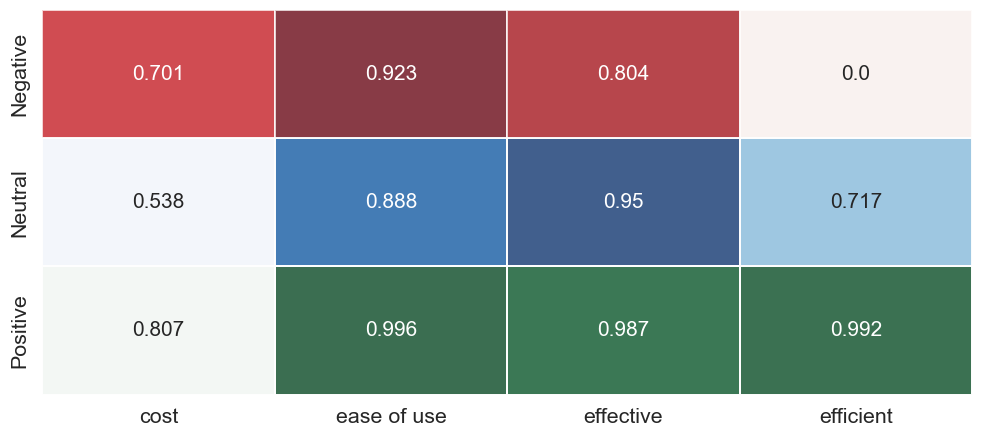

In [ ]:
table = pd.pivot_table(df, values='max', index=['sentiment'], columns=['align_type'], aggfunc=np.mean,fill_value=0)
plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=True, cmap="Greens", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table.copy()
data2.loc['Negative'] = float('nan')
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=True, cmap="Blues", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=True, cmap="Reds", alpha=0.75,fmt=".3",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Accuracy evaluation

In [ ]:
df = pd.read_csv('aggregated_handlabeled.csv', index_col = [0])
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effective', 'efficient']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

In [ ]:
# sentiment analysis
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower'][0:99]:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80


In [ ]:
# zero-shot classifier
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")
type = ['cost', 'efficient', 'effective', 'ease of use']
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(99):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0


C:\Users\WJ.DESKTOP-VH0S9RM\AppData\Local\Temp\ipykernel_10780\2091210579.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]


20
40
60
80


## Evaluate sentiment

In [7]:
# Evaluate sentiment
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
def imputation1(list):
    i = []
    for prediction in list:
        if prediction == "Positive":
            i.append(1)
        elif prediction == "Neutral":
            i.append(0)
        else:
            i.append(-1)    
    return(i)
df['sentiment'] = imputation1(df['sentiment'])
df['sentiment_m'] = imputation1(df['sentiment_m'])
print(classification_report(df['sentiment'], df['sentiment_m']))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       400

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



## Evaluate zero shot

In [5]:
# Evaluate zero-shot
def imputation(list):
    i = []
    for prediction in list:
        if prediction < 0.7:
            i.append(0)
        else:
            i.append(1)
    
    return(i)
df['cost_m'] = imputation(df['cost_m'])
df['efficient_m'] = imputation(df['efficient_m'])
df['effective_m'] = imputation(df['effective_m'])
df['ease of use_m'] = imputation(df['ease of use_m'])

### 1) cost

In [8]:
print(classification_report(df['cost'], df['cost_m']))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       388
         1.0       0.38      0.92      0.54        12

    accuracy                           0.95       400
   macro avg       0.69      0.94      0.76       400
weighted avg       0.98      0.95      0.96       400



In [ ]:
ROC_AUC = roc_auc_score(df['cost'], df['cost_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.9351


### 2) efficient

In [ ]:
print(classification_report(df['efficient'], df['efficient_m']))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93       363
         1.0       0.38      0.65      0.48        37

    accuracy                           0.87       400
   macro avg       0.67      0.77      0.70       400
weighted avg       0.91      0.87      0.88       400



In [ ]:
ROC_AUC = roc_auc_score(df['efficient'], df['efficient_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7706


### 3) effective

In [ ]:
print(classification_report(df['effective'], df['effective_m']))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       306
         1.0       0.97      0.73      0.84        94

    accuracy                           0.93       400
   macro avg       0.95      0.86      0.90       400
weighted avg       0.94      0.93      0.93       400



In [ ]:
ROC_AUC = roc_auc_score(df['effective'], df['effective_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8638


### 4) ease of use

In [ ]:
print(classification_report(df['ease of use'], df['ease of use_m']))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       381
         1.0       0.34      0.74      0.47        19

    accuracy                           0.92       400
   macro avg       0.66      0.83      0.71       400
weighted avg       0.96      0.92      0.93       400



In [ ]:
ROC_AUC = roc_auc_score(df['ease of use'], df['ease of use_m'])
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.8330


## Compare zero-shot against a Naive classifier

In [ ]:
def naive(list):
    avg  = np.mean(list)

    if avg >= 0.5:
        i = 1
    else:
        i = 0

    return([i] * len(list))
df['naive_cost'] = naive(df['cost'])
df['naive_efficient'] = naive(df['efficient'])
df['naive_effective'] = naive(df['effective'])
df['naive_easeofuse'] = naive(df['ease of use'])

In [ ]:
# cost
print(classification_report(df['cost'], df['naive_cost']))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       388
         1.0       0.00      0.00      0.00        12

    accuracy                           0.97       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.94      0.97      0.96       400



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# efficient
print(classification_report(df['efficient'], df['naive_efficient']))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       363
         1.0       0.00      0.00      0.00        37

    accuracy                           0.91       400
   macro avg       0.45      0.50      0.48       400
weighted avg       0.82      0.91      0.86       400



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# effective
print(classification_report(df['effective'], df['naive_effective']))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       306
         1.0       0.00      0.00      0.00        94

    accuracy                           0.77       400
   macro avg       0.38      0.50      0.43       400
weighted avg       0.59      0.77      0.66       400



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ease of use
print(classification_report(df['ease of use'], df['naive_easeofuse']))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       381
         1.0       0.00      0.00      0.00        19

    accuracy                           0.95       400
   macro avg       0.48      0.50      0.49       400
weighted avg       0.91      0.95      0.93       400



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df.to_csv('aggregated_evaluation.csv')

In [33]:
#import pandas as pd
#df=pd.read_csv('aggregated_evaluation.csv')

In [41]:
#!pip install transformers

# Visualization

In [38]:
report_sentiment = classification_report(df['sentiment'], df['sentiment_m'], output_dict=True)

def accuracy(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  return (type, report['1.0']['recall'])

def accuracy_matrix(type):
  report = classification_report(df[type], df[type+'_m'], output_dict=True)
  data= np.ones((100, 100))
  data[0:int(report_sentiment['accuracy']*100),0:int(report['1.0']['recall']*100)] = 0.0 
  return data

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.ticker as mticker  
import matplotlib.patches as mpatches

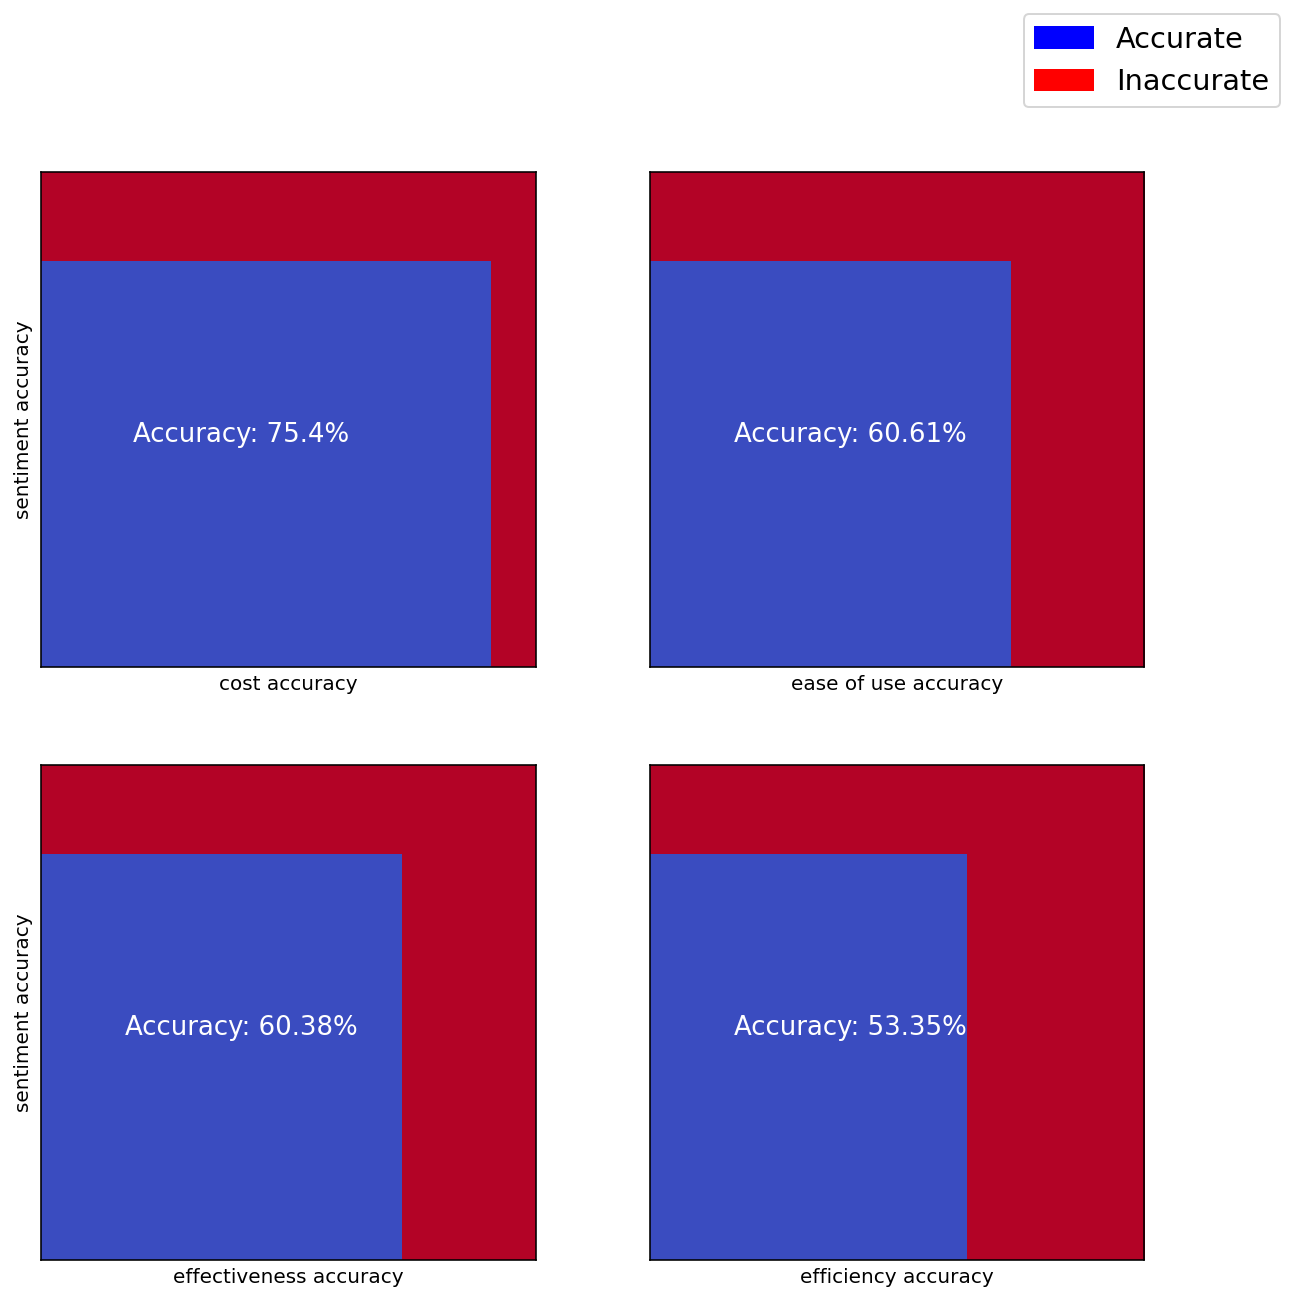

In [40]:
#fig, ax = plt.subplots()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)

fig.set_figheight(10)
fig.set_figwidth(10)

img1 = ax1.imshow(accuracy_matrix('cost'),cmap='coolwarm',origin='lower')
img2 = ax2.imshow(accuracy_matrix('ease of use'),cmap='coolwarm',origin='lower')
img3 = ax3.imshow(accuracy_matrix('effective'),cmap='coolwarm',origin='lower')
img4 = ax4.imshow(accuracy_matrix('efficient'),cmap='coolwarm',origin='lower')

img1=plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
img1=plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())

ax1.set_xlabel('cost accuracy')
ax1.set_ylabel('sentiment accuracy')
ax3.set_ylabel('sentiment accuracy')
ax2.set_xlabel('ease of use accuracy')
ax3.set_xlabel('effectiveness accuracy')
ax4.set_xlabel('efficiency accuracy')

ax1.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('cost')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax2.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('ease of use')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax3.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('effective')[1]*100,2))+'%', fontsize=13, c='white',ha='center')
ax4.text(40, 45, 'Accuracy: '+ str(round(report_sentiment['accuracy']*accuracy('efficient')[1]*100,2))+'%', fontsize=13, c='white',ha='center')

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

blue_patch = mpatches.Patch(color='blue', label='Accurate')
red_patch = mpatches.Patch(color='red', label='Inaccurate')
fig.legend(handles=[blue_patch, red_patch],loc='upper right',fontsize='x-large')